In [177]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory  # pip install tf-nightly
from tensorflow.keras.callbacks import ModelCheckpoint

In [178]:
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [179]:
DATASET_DIR = "./dataset/sdd"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (128, 128)

BATCH_SIZE = 128

In [180]:
# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='categorical',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 16229 files belonging to 120 classes.
Found 4111 files belonging to 120 classes.


train_imgs.shape:  (128, 128, 128, 3)
train_labels.shape:  (128, 120)
['n02093859-Kerry_blue_terrier', 'n02105855-Shetland_sheepdog', 'n02110958-pug', 'n02111129-Leonberg', 'n02102177-Welsh_springer_spaniel', 'n02086646-Blenheim_spaniel', 'n02108422-bull_mastiff', 'n02108000-EntleBucher', 'n02099601-golden_retriever', 'n02095314-wire-haired_fox_terrier', 'n02086240-Shih-Tzu', 'n02102973-Irish_water_spaniel', 'n02109047-Great_Dane', 'n02096177-cairn', 'n02099849-Chesapeake_Bay_retriever', 'n02096177-cairn', 'n02100583-vizsla', 'n02102318-cocker_spaniel', 'n02090721-Irish_wolfhound', 'n02115641-dingo', 'n02097130-giant_schnauzer', 'n02097130-giant_schnauzer', 'n02109525-Saint_Bernard', 'n02107683-Bernese_mountain_dog', 'n02099267-flat-coated_retriever', 'n02096051-Airedale', 'n02095314-wire-haired_fox_terrier', 'n02112350-keeshond', 'n02105162-malinois', 'n02105855-Shetland_sheepdog', 'n02088364-beagle', 'n02090379-redbone', 'n02106030-collie', 'n02095570-Lakeland_terrier', 'n02089867-Wa

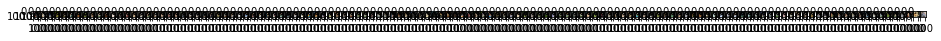

In [181]:
# show train batch
train_imgs, train_labels = next(iter(train_ds))

print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [182]:
# show dataset info
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 127
test dataset size: 33

class names:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfol

In [183]:
class SE_Block(Model):
    def __init__(self, filters):
        super(SE_Block, self).__init__(name='')

        r = 8

        self.global_avg_pool = GlobalAveragePooling2D()

        self.fc1 = Dense(filters / r, activation='relu')

        self.fc2 = Dense(filters, activation='sigmoid')

    def call(self, x):
        c = x.shape[-1]
        inp = x
        x = self.global_avg_pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.reshape(x, [-1, 1, 1, c])
        x *= inp

        return x

In [184]:
class ResBasicBlock(Model):
    def __init__(self, filters, kernel_size, padding='same', strides=1):
        super(ResBasicBlock, self).__init__(name='')

        flt1, flt2, flt3 = filters

        self.conv1 = Conv2D(flt1, 1, padding=padding, strides=strides)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.covn2 = Conv2D(flt2, kernel_size, padding=padding)

        self.conv3 = Conv2D(flt3, 1, padding=padding)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.reshape_conv = Conv2D(flt3, 1, padding=padding, strides=strides)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()

    def call(self, x):
        inp = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.covn2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        inp = self.reshape_conv(inp)
        inp = self.bn4(inp)
        x += inp

        x = tf.nn.relu(x)

        return x

In [185]:
class ResBlockA(Model):
    def __init__(self):
        super(ResBlockA, self).__init__(name='')

        filters = (32, 32, 128)

        self.res_blocks = Sequential([])

        for _ in range(3):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [186]:
class ResBlockB(Model):
    def __init__(self):
        super(ResBlockB, self).__init__(name='')

        filters = (64, 64, 256)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(3):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [187]:
class ResBlockC(Model):
    def __init__(self):
        super(ResBlockC, self).__init__(name='')

        filters = (128, 128, 512)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(5):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [188]:
class ResBlockD(Model):
    def __init__(self):
        super(ResBlockD, self).__init__(name='')

        filters = (512, 512, 1024)

        self.res_blocks = Sequential(
            [ResBasicBlock(filters, kernel_size=3, strides=2)])

        for _ in range(2):
            self.res_blocks.add(ResBasicBlock(filters, kernel_size=3))

    def call(self, x):
        x = self.res_blocks(x)

        return x

In [189]:
class BokuNet(Model):
    def __init__(self):
        super(BokuNet, self).__init__(name='BokuNet')
        self.conv1 = Conv2D(32, 7, strides=2)
        self.max_pool = MaxPooling2D((3, 3), strides=2)

        self.res_bloack_a = ResBlockA()
        self.res_block_b = ResBlockB()
        #         self.res_block_c = ResBlockC()
        #         self.res_block_d = ResBlockD()

        self.avg_pool = AveragePooling2D()
        self.flatten = Flatten()

        self.out_fc = Dense(120, activation='softmax')


#         self.drop1 = Dropout(0.5)

    def call(self, x):
        x = x / 255  # normalization

        x = self.conv1(x)
        #         print(x.shape)
        x = self.max_pool(x)
        #         print(x.shape)

        x = self.res_bloack_a(x)
        #         print('a', x.shape)

        x = self.res_block_b(x)
        #         print('b', x.shape)

        #         x = self.res_block_c(x)
        #         print('c', x.shape)

        #         x = self.res_block_d(x)
        #         print('d', x.shape)

        x = self.avg_pool(x)
        #         print(x.shape)

        x = self.flatten(x)

        x = self.out_fc(x)

        return x

In [190]:
# model = BokuNet()
# # model = SE_Block(64)
# imgs_shape = (128, 32, 32, 3)
# model.build(imgs_shape)
# print(model.summary())

In [209]:
class KimiNet(Model):
    def __init__(self):
        super(KimiNet, self).__init__(name='KimiNet')
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.max_pool1 = MaxPooling2D((2, 2))
        #         self.max_pool2 = MaxPooling2D((2, 2))

        self.res_basic_block1 = ResBasicBlock(filters=(32, 32, 128),
                                              kernel_size=3, strides=2)

        self.se_block1 = SE_Block(128)
        self.bn1 = BatchNormalization()

        self.res_basic_block2 = ResBasicBlock(filters=(64, 64, 256),
                                              kernel_size=3, strides=2)

        self.se_block2 = SE_Block(256)
        self.bn2 = BatchNormalization()
        
        self.res_basic_block3 = ResBasicBlock(filters=(32, 32, 128),
                                              kernel_size=3, strides=2)
        

        self.avg_pool = AveragePooling2D((2, 2))
        self.flatten = Flatten()
        self.out_fc = Dense(120, activation='softmax')

        self.drop1 = Dropout(0.5)

    def call(self, x):
        x = x / 255.0  # normalization

        x = self.conv1(x)
        x = self.max_pool1(x)

        x = self.res_basic_block1(x)
        x = self.se_block1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.res_basic_block2(x)
        x = self.se_block2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        
        x = self.res_basic_block3(x)

        x = self.avg_pool(x)
        x = self.flatten(x)

        x = self.drop1(x)

        x = self.out_fc(x)

        return x

In [210]:
model = KimiNet()
imgs, labels= next(iter(train_ds))
model.build(imgs.shape)
print(model.summary())

Model: "KimiNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_347 (Conv2D)          multiple                  896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling multiple                  0         
_________________________________________________________________
res_basic_block_77 (ResBasic multiple                  20032     
_________________________________________________________________
se__block_41 (SE_Block)      multiple                  4240      
_________________________________________________________________
batch_normalization_333 (Bat multiple                  512       
_________________________________________________________________
res_basic_block_78 (ResBasic multiple                  97408     
_________________________________________________________________
se__block_42 (SE_Block)      multiple                  1667

In [216]:
EPOCHS = 3

checkpoint_path = "checkpoint/kimi_sdd/cp.ckpt"

if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              mode='min',
                              verbose=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/3
127/127 [==============================] - ETA: 0s - loss: 2.4060 - accuracy: 0.3990
Epoch 00001: val_loss improved from inf to 3.84646, saving model to checkpoint/kimi_sdd\cp.ckpt
127/127 [==============================] - 62s 485ms/step - loss: 2.4060 - accuracy: 0.3990 - val_loss: 3.8465 - val_accuracy: 0.1367
Epoch 2/3
127/127 [==============================] - ETA: 0s - loss: 2.3969 - accuracy: 0.4016
Epoch 00002: val_loss did not improve from 3.84646
127/127 [==============================] - 61s 480ms/step - loss: 2.3969 - accuracy: 0.4016 - val_loss: 3.8467 - val_accuracy: 0.1365
Epoch 3/3
127/127 [==============================] - ETA: 0s - loss: 2.4148 - accuracy: 0.4008
Epoch 00003: val_loss did not improve from 3.84646
127/127 [==============================] - 61s 482ms/step - loss: 2.4148 - accuracy: 0.4008 - val_loss: 3.8467 - val_accuracy: 0.1369


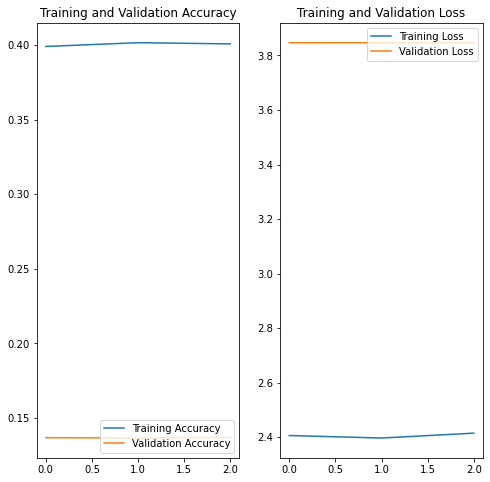

In [217]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()